# Fusing Depth Data

## Overview

Most cryptocurrency exchanges do not deliver true tick-by-tick Level-2 data. Instead, they provide conflated feeds in which individual order-book updates are aggregated over short intervals. For example, Binance Futures’ `depth@0ms` stream is still aggregated: You can confirm that its best-bid-offer (BBO) values update less frequently than those in the `bookTicker` stream, which captures every BBO change. Other venues state similar limitations explicitly—Bybit, for instance, publishes the Level 1 data (BBO) every 10ms, the Level 50 data every 20ms, and the Level 200 data every 100ms.

To generate accurate fill simulations and realistic backtesting results, you must therefore fuse multiple depth streams into a single feed that preserves the highest possible update frequency and granularity.

Let’s see Binance Futures as our example.

## Data Preparation

In [1]:
# !wget https://datasets.tardis.dev/v1/binance-futures/trades/2025/05/01/BTCUSDT.csv.gz -O BTCUSDT_trades_20250501.csv.gz
# !wget https://datasets.tardis.dev/v1/binance-futures/incremental_book_L2/2025/05/01/BTCUSDT.csv.gz -O BTCUSDT_incremental_book_L2_20250501.csv.gz
# !wget https://datasets.tardis.dev/v1/binance-futures/book_ticker/2025/05/01/BTCUSDT.csv.gz -O BTCUSDT_book_ticker_20250501.csv.gz

In [2]:
from hftbacktest.data.utils import tardis

tardis.convert(
    [
        'BTCUSDT_trades_20250501.csv.gz',
        'BTCUSDT_incremental_book_L2_20250501.csv.gz'
    ],
    output_filename='BTCUSDT_20250501.npz',
    buffer_size=1_000_000_000,
    snapshot_mode='process'
)

Reading BTCUSDT_trades_20250501.csv.gz
Reading BTCUSDT_incremental_book_L2_20250501.csv.gz
Correcting the latency
Correcting the event order
Saving to BTCUSDT_20250501.npz


array([(3758096386, 1746057600043000000, 1746057600046245000, 94125.2, 1.0000e-02, 0, 0, 0.),
       (3758096387, 1746057600072000000, 1746057601025373000, 93954.8, 0.0000e+00, 0, 0, 0.),
       (3758096388, 1746057600072000000, 1746057601025373000, 94125.1, 1.0798e+01, 0, 0, 0.),
       ...,
       (3758096385, 1746143999978000000, 1746143999980195000, 96406. , 1.5590e+00, 0, 0, 0.),
       (3758096385, 1746143999978000000, 1746143999980195000, 96411.2, 6.1000e-02, 0, 0, 0.),
       (3758096385, 1746143999978000000, 1746143999980195000, 96423.2, 1.0130e+01, 0, 0, 0.)],
      shape=(106343798,), dtype={'names': ['ev', 'exch_ts', 'local_ts', 'px', 'qty', 'order_id', 'ival', 'fval'], 'formats': ['<u8', '<i8', '<i8', '<f8', '<f8', '<u8', '<i8', '<f8'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64, 'aligned': True})

Use the backtester to replay the data, get the BBO values from the Level-2 depth feed to compare it with the BBO obtained from the book ticker stream.

In [3]:
import numpy as np
from numba import njit
from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest
)

@njit
def record_l2_bbo(
    hbt,
    timeout
):
    asset_no = 0
    t = 0
    l2_bbo = np.full((30_000_000, 5), np.nan, np.float64)
    prev_best_bid = np.nan
    prev_best_ask = np.nan
    prev_best_bid_qty = np.nan
    prev_best_ask_qty = np.nan

    # 0: Timeout(no market feed received within the timeout interval)
    # 2: Market Feed
    # Otherwise, an error occurs.
    while hbt.wait_next_feed(False, timeout) in [0, 2]: 
        depth = hbt.depth(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        best_bid_qty = depth.bid_qty_at_tick(depth.best_bid_tick)
        best_ask_qty = depth.ask_qty_at_tick(depth.best_ask_tick)
        
        if (
            best_bid != prev_best_bid 
            or best_ask != prev_best_ask
            or best_bid_qty != prev_best_bid_qty
            or best_ask_qty != prev_best_ask_qty
        ):
            l2_bbo[t, 0] = hbt.current_timestamp
            l2_bbo[t, 1] = prev_best_bid = best_bid
            l2_bbo[t, 2] = prev_best_ask = best_ask
            l2_bbo[t, 3] = prev_best_bid_qty = best_bid_qty
            l2_bbo[t, 4] = prev_best_ask_qty = best_ask_qty
        
            t += 1
        
            if t >= len(l2_bbo):
                raise Exception

    return l2_bbo[:t]

In [4]:
%%time

roi_lb = 50000
roi_ub = 150000

asset = (
    BacktestAsset()
        .data(['BTCUSDT_20250501.npz'])
        .linear_asset(1.0) 
        .constant_order_latency(0, 0)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

timeout = 100_000_000 # 100ms

l2_bbo = record_l2_bbo(
    hbt,
    timeout
)

_ = hbt.close()

CPU times: user 40.5 s, sys: 4.34 s, total: 44.9 s
Wall time: 43.4 s


## Comparing BBO updates: Level-2 (depth@0ms) Stream vs bookTicker Stream

The `bookTicker` stream delivers updates more often and leads the Level-2 feed by a small margin.

In [5]:
import polars as pl
from matplotlib import pyplot as plt

In [6]:
df_l2_bbo = pl.DataFrame(l2_bbo)
df_l2_bbo.columns = ['Local Timestamp', 'Bid', 'Ask', 'Bid Qty', 'Ask Qty']

df_l2_bbo = df_l2_bbo.with_columns(
    pl.from_epoch('Local Timestamp', time_unit='ns')
).filter(
    (pl.col('Local Timestamp') > pl.lit('2025-05-01 14:36:03').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')) &
    (pl.col('Local Timestamp') < pl.lit('2025-05-01 14:36:5').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S'))
)

In [7]:
df_book_ticker = pl.read_csv('BTCUSDT_book_ticker_20250501.csv.gz').with_columns(
    pl.from_epoch('local_timestamp', time_unit='us')
).select(
    'local_timestamp', 'bid_price', 'ask_price', 'bid_amount', 'ask_amount'
).filter(
    (pl.col('local_timestamp') > pl.lit('2025-05-01 14:36:03').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')) &
    (pl.col('local_timestamp') < pl.lit('2025-05-01 14:36:5').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S'))
)

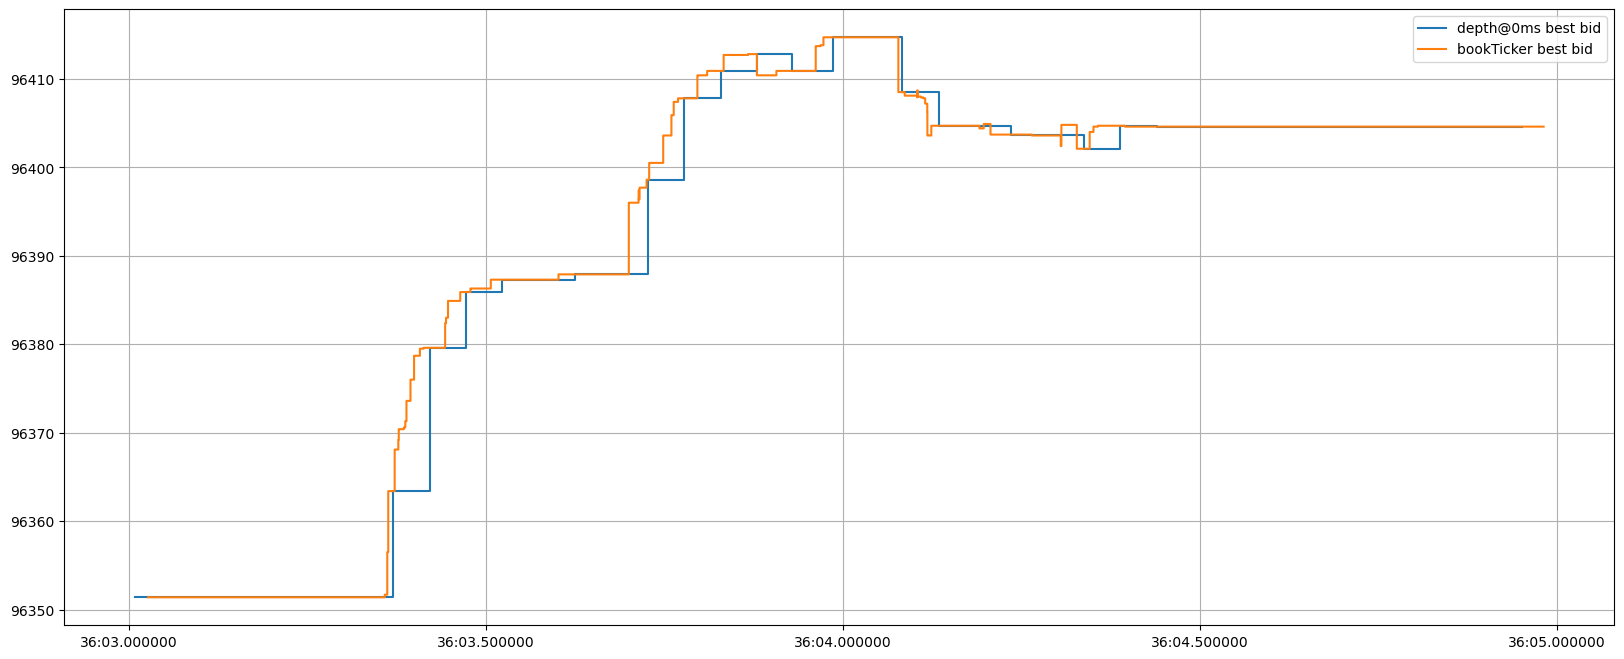

In [8]:
plt.figure(figsize=(20, 8))
plt.step(df_l2_bbo['Local Timestamp'], df_l2_bbo['Bid'], where='post')
plt.step(df_book_ticker['local_timestamp'], df_book_ticker['bid_price'], where='post')
plt.legend(['depth@0ms best bid', 'bookTicker best bid'])
plt.grid()

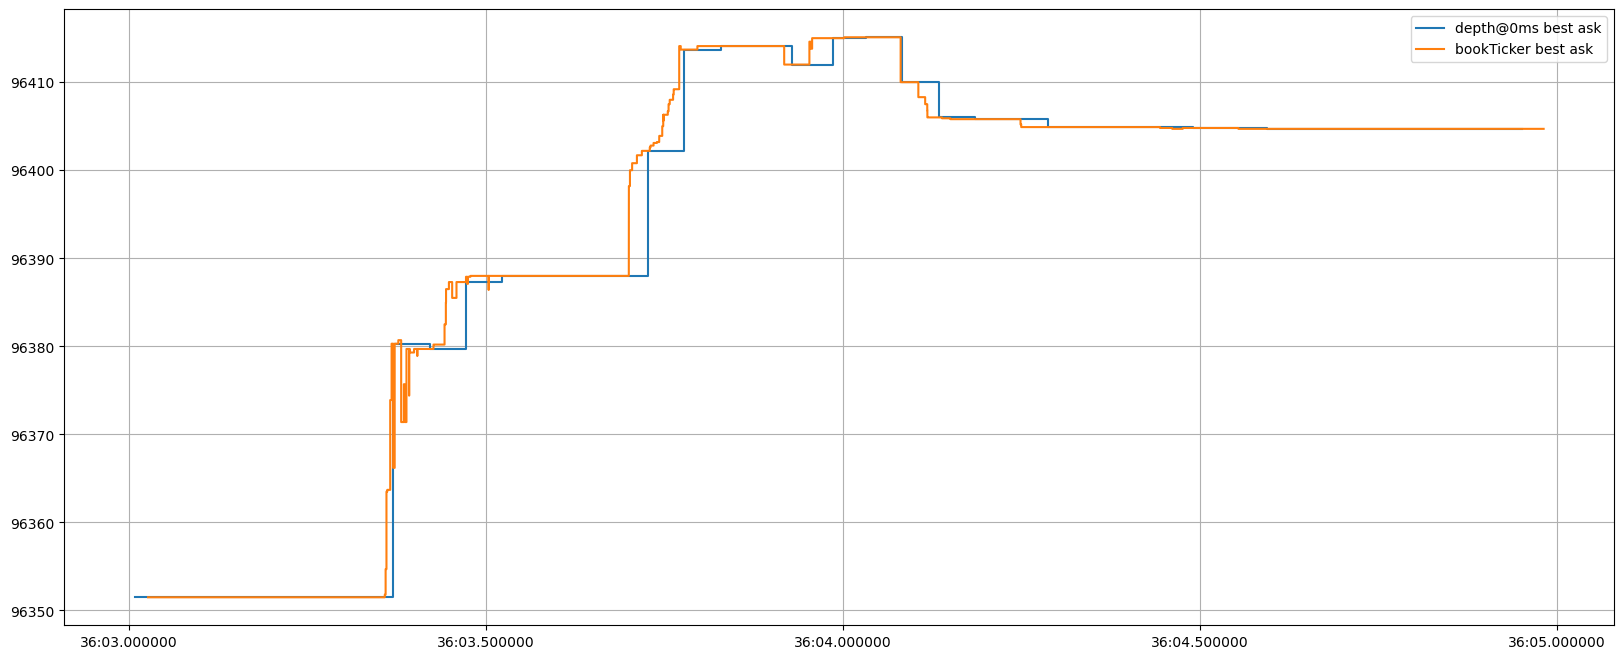

In [9]:
plt.figure(figsize=(20, 8))
plt.step(df_l2_bbo['Local Timestamp'], df_l2_bbo['Ask'], where='post')
plt.step(df_book_ticker['local_timestamp'], df_book_ticker['ask_price'], where='post')
plt.legend(['depth@0ms best ask', 'bookTicker best ask'])
plt.grid()

You’ll notice that the `bookTicker` stream delivers updates far more frequently—especially when you factor in changes to both price and quantity.

In [10]:
with pl.Config(tbl_rows=100):
    print(df_l2_bbo)

shape: (39, 5)
┌───────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│ Local Timestamp               ┆ Bid     ┆ Ask     ┆ Bid Qty ┆ Ask Qty │
│ ---                           ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│ datetime[ns]                  ┆ f64     ┆ f64     ┆ f64     ┆ f64     │
╞═══════════════════════════════╪═════════╪═════════╪═════════╪═════════╡
│ 2025-05-01 14:36:03.008176128 ┆ 96351.4 ┆ 96351.5 ┆ 6.344   ┆ 7.159   │
│ 2025-05-01 14:36:03.060811008 ┆ 96351.4 ┆ 96351.5 ┆ 6.368   ┆ 1.297   │
│ 2025-05-01 14:36:03.112276992 ┆ 96351.4 ┆ 96351.5 ┆ 6.528   ┆ 0.128   │
│ 2025-05-01 14:36:03.163234048 ┆ 96351.4 ┆ 96351.5 ┆ 6.878   ┆ 0.188   │
│ 2025-05-01 14:36:03.215074048 ┆ 96351.4 ┆ 96351.5 ┆ 6.584   ┆ 2.819   │
│ 2025-05-01 14:36:03.266274048 ┆ 96351.4 ┆ 96351.5 ┆ 6.399   ┆ 1.996   │
│ 2025-05-01 14:36:03.316154112 ┆ 96351.4 ┆ 96351.5 ┆ 6.399   ┆ 2.127   │
│ 2025-05-01 14:36:03.369733888 ┆ 96363.4 ┆ 96380.3 ┆ 1.12    ┆ 0.006   │
│ 2025-05-01 14:36:03.4

In [11]:
with pl.Config(tbl_rows=100):
    print(df_book_ticker)

shape: (1_432, 5)
┌────────────────────────────┬───────────┬───────────┬────────────┬────────────┐
│ local_timestamp            ┆ bid_price ┆ ask_price ┆ bid_amount ┆ ask_amount │
│ ---                        ┆ ---       ┆ ---       ┆ ---        ┆ ---        │
│ datetime[μs]               ┆ f64       ┆ f64       ┆ f64        ┆ f64        │
╞════════════════════════════╪═══════════╪═══════════╪════════════╪════════════╡
│ 2025-05-01 14:36:03.027063 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.157      │
│ 2025-05-01 14:36:03.027070 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.154      │
│ 2025-05-01 14:36:03.027072 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.121      │
│ 2025-05-01 14:36:03.029315 ┆ 96351.4   ┆ 96351.5   ┆ 6.35       ┆ 7.121      │
│ 2025-05-01 14:36:03.030317 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.121      │
│ 2025-05-01 14:36:03.045954 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.119      │
│ 2025-05-01 14:36:03.049547 ┆ 96351.4   ┆ 96351.5   ┆ 6.348      ┆ 7.119      │
│ 2025-05-

## Fusing Multiple Depth Feeds

To obtain the most frequent and fine-grained market depth updates, it is necessary to combine the depth feed with the book ticker feed. The [`FuseMarketDepth`](https://hftbacktest.readthedocs.io/en/latest/reference/data_utilities.html#hftbacktest.binding.FuseMarketDepth) utility helps fuse multiple depth update streams into a single order book view. HftBacktest includes a fused converter function [`convert_fuse`](https://hftbacktest.readthedocs.io/en/latest/reference/hftbacktest.data.utils.tardis.html#hftbacktest.data.utils.tardis.convert_fuse) for Tardis data.
 
<div class="alert alert-info">

**Note: Handling Timestamp Inconsistencies**  
When fusing multiple depth feeds, it's possible that an event with a later exchange timestamp may be received before an event with an earlier timestamp from another feed. Accurately reconstructing the order book in such cases would require building a separate order book for each feed and then combining them.

However, this utility builds only a single consolidated order book, where:
- Updates are processed in order of local receipt time.
- The price-level information are updated based on the exchange timestamp.

If an older exchange-timestamped update arrives after a newer one for the same price level, it is discarded. This approach may lead to slight discrepancies between the local order book state and the actual state on the exchange.

</div>

<div class="alert alert-info">

**Note: Order Book Inconsistency Between Feeds**  
Each depth feed may present a different snapshot of the order book. When combining them, inconsistencies may arise even if the fused result reflects more up-to-date information.

For example:

- A depth feed may show a best bid/ask (BBO) at 10/11.
- A more current book ticker feed may show BBO at 10/14.

When fused:

The resulting book shows BBO at 10/14.
But price levels above 14 (e.g., 15 and higher) still reflect outdated data from the original depth feed. This results in a partially updated and inconsistent order book. To maintain consistency with the depth feed’s original intent, you would need to build and maintain a separate order book for each feed.

</div>

In [12]:
from hftbacktest.data.utils.tardis import convert_fuse

convert_fuse(
    'BTCUSDT_trades_20250501.csv.gz', 
    'BTCUSDT_incremental_book_L2_20250501.csv.gz',
    'BTCUSDT_book_ticker_20250501.csv.gz',
    tick_size=0.1,
    lot_size=0.001,
    output_filename='BTCUSDT_fused_20250501.npz'
)

Correcting the latency
Correcting the event order
Saving to BTCUSDT_fused_20250501.npz


array([(3489660929, 1746057600036000000, 1746057600038318000, 94125.2, 9.7830e+00, 0, 0, 0.),
       (3758096385, 1746057600036000000, 1746057600038318000, 94125.1, 1.0882e+01, 0, 0, 0.),
       (2684354562, 1746057600043000000, 1746057600046245000, 94125.2, 1.0000e-02, 0, 0, 0.),
       ...,
       (3758096385, 1746143999978000000, 1746143999980195000, 96423.2, 1.0130e+01, 0, 0, 0.),
       (3758096385, 1746143999979000000, 1746143999982227000, 96423.2, 9.8140e+00, 0, 0, 0.),
       (3758096385, 1746143999982000000, 1746143999985629000, 96423.2, 9.8170e+00, 0, 0, 0.)],
      shape=(123281421,), dtype={'names': ['ev', 'exch_ts', 'local_ts', 'px', 'qty', 'order_id', 'ival', 'fval'], 'formats': ['<u8', '<i8', '<i8', '<f8', '<f8', '<u8', '<i8', '<f8'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64, 'aligned': True})

In [13]:
roi_lb = 50000
roi_ub = 150000

asset = (
    BacktestAsset()
        .data(['BTCUSDT_fused_20250501.npz'])
        .linear_asset(1.0) 
        .constant_order_latency(0, 0)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

timeout = 100_000_000 # 100ms

l2_bbo_fused = record_l2_bbo(
    hbt,
    timeout
)

_ = hbt.close()

In [14]:
df_l2_bbo_fused = pl.DataFrame(l2_bbo_fused)
df_l2_bbo_fused.columns = ['Local Timestamp', 'Bid', 'Ask', 'Bid Qty', 'Ask Qty']

df_l2_bbo_fused = df_l2_bbo_fused.with_columns(
    pl.from_epoch('Local Timestamp', time_unit='ns')
).filter(
    (pl.col('Local Timestamp') > pl.lit('2025-05-01 14:36:03').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')) &
    (pl.col('Local Timestamp') < pl.lit('2025-05-01 14:36:5').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S'))
)

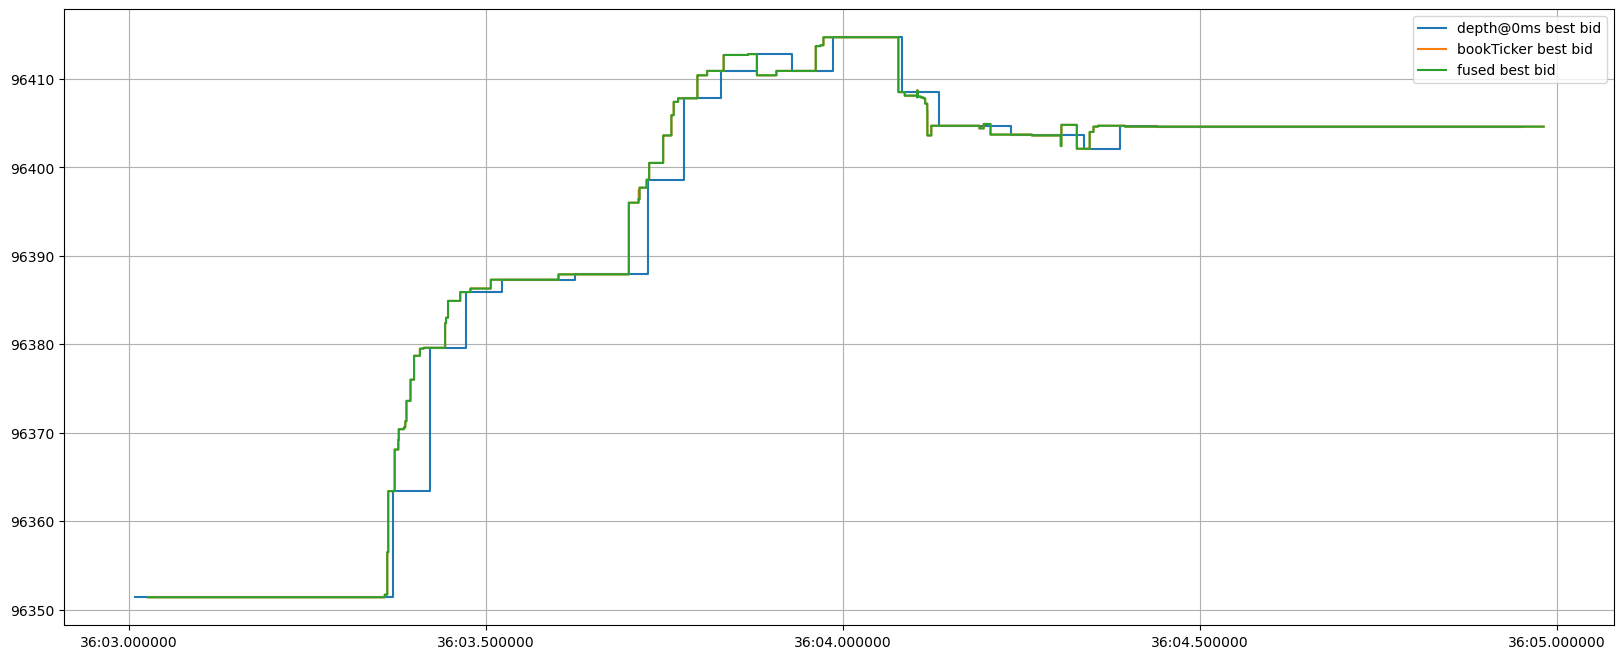

In [15]:
plt.figure(figsize=(20, 8))
plt.step(df_l2_bbo['Local Timestamp'], df_l2_bbo['Bid'], where='post')
plt.step(df_book_ticker['local_timestamp'], df_book_ticker['bid_price'], where='post')
plt.step(df_l2_bbo_fused['Local Timestamp'], df_l2_bbo_fused['Bid'], where='post')
plt.legend(['depth@0ms best bid', 'bookTicker best bid', 'fused best bid'])
plt.grid()

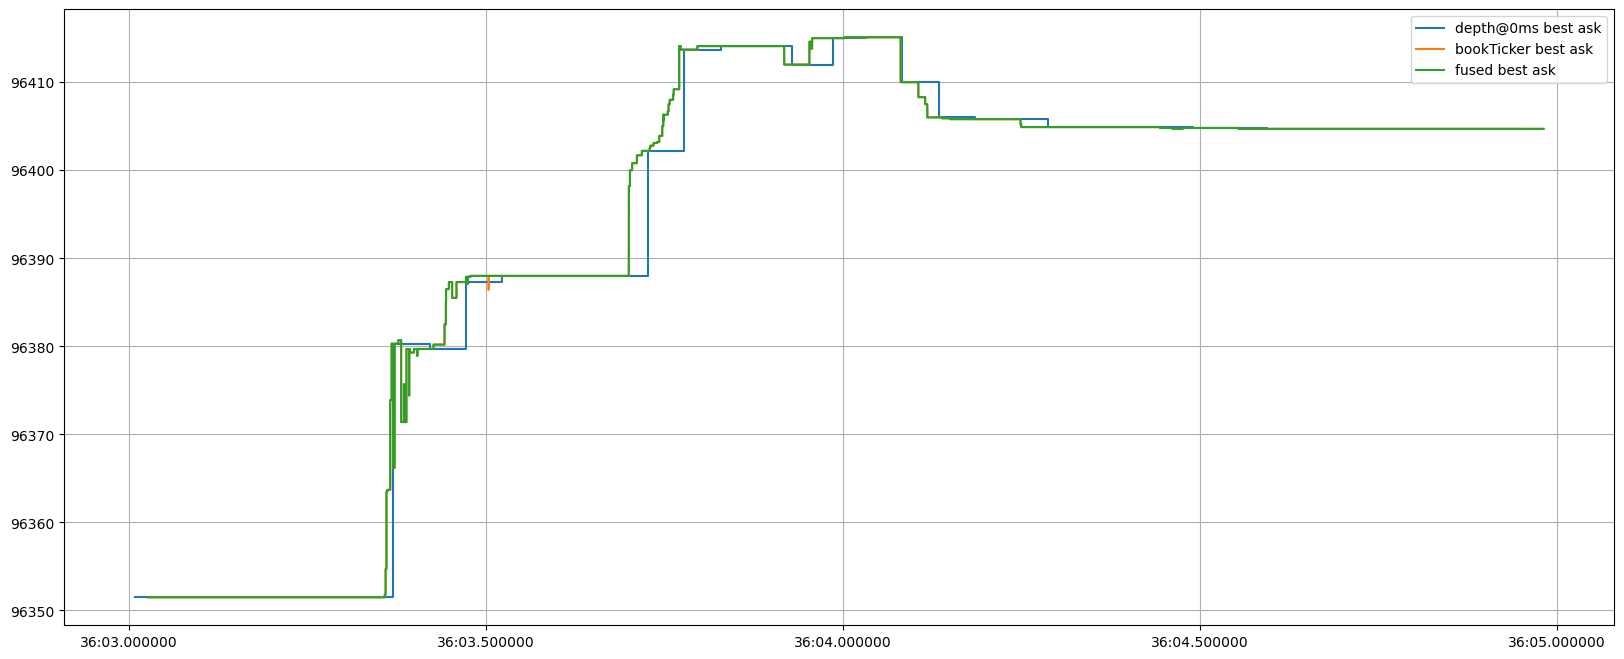

In [16]:
plt.figure(figsize=(20, 8))
plt.step(df_l2_bbo['Local Timestamp'], df_l2_bbo['Ask'], where='post')
plt.step(df_book_ticker['local_timestamp'], df_book_ticker['ask_price'], where='post')
plt.step(df_l2_bbo_fused['Local Timestamp'], df_l2_bbo_fused['Ask'], where='post')
plt.legend(['depth@0ms best ask', 'bookTicker best ask', 'fused best ask'])
plt.grid()

## Backtest Results Comparison

We now compare backtesting results between fused and non-fused data.

In [17]:
from numba import uint64
from numba.typed import Dict
from hftbacktest import (
    GTX,
    LIMIT,
    BUY,
    SELL,
    Recorder
)
from hftbacktest.stats import LinearAssetRecord

@njit
def basic_mm(
    hbt,
    stat,
    half_spread,
    skew,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval
):
    asset_no = 0

    tick_size = hbt.depth(0).tick_size
    lot_size = hbt.depth(0).lot_size
    
    while hbt.elapse(interval) == 0:
        hbt.clear_inactive_orders(asset_no)

        orders = hbt.orders(asset_no)
        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        
        mid_price = (best_bid + best_ask) / 2.0
        mid_price_tick = (depth.best_bid_tick + depth.best_ask_tick) / 2.0

        #--------------------------------------------------------
        # Computes bid price and ask price.

        order_qty = max(round((order_qty_dollar / mid_price) / lot_size) * lot_size, lot_size)
        
        normalized_position = position / order_qty

        relative_bid_depth = half_spread + skew * normalized_position
        relative_ask_depth = half_spread - skew * normalized_position

        bid_price = min(mid_price * (1.0 - relative_bid_depth), best_bid)
        ask_price = max(mid_price * (1.0 + relative_ask_depth), best_ask)
        
        bid_price = np.floor(bid_price / tick_size) * tick_size
        ask_price = np.ceil(ask_price / tick_size) * tick_size

        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price < max_position_dollar and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price > -max_position_dollar and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        stat.record(hbt)

In [18]:
roi_lb = 50000
roi_ub = 150000

half_spread = 0.0005 # a ratio relative to the fair price
skew = half_spread / 20
interval = 100_000_000 # in nanoseconds. 100ms
order_qty_dollar = 50_000
max_position_dollar = 1_000_000
grid_num = 1
grid_interval = 0.1

asset = (
    BacktestAsset()
        .data(['BTCUSDT_nonfused_20250501.npz'])
        .linear_asset(1.0) 
        .intp_order_latency(['../latency/order_latency_20250501.npz'])
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

basic_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval
)

_ = hbt.close()

### Backtesting with Non-Fused Data

In [19]:
data = recorder.get(0)
stats = (
    LinearAssetRecord(data)
        .resample('1s')
        .stats(book_size=1_000_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-05-01 00:00:00,2025-05-01 23:59:59,11.17529,15.92313,0.001077,0.00115,128.001481,6.4003,0.936022,0.000168,402046.58425


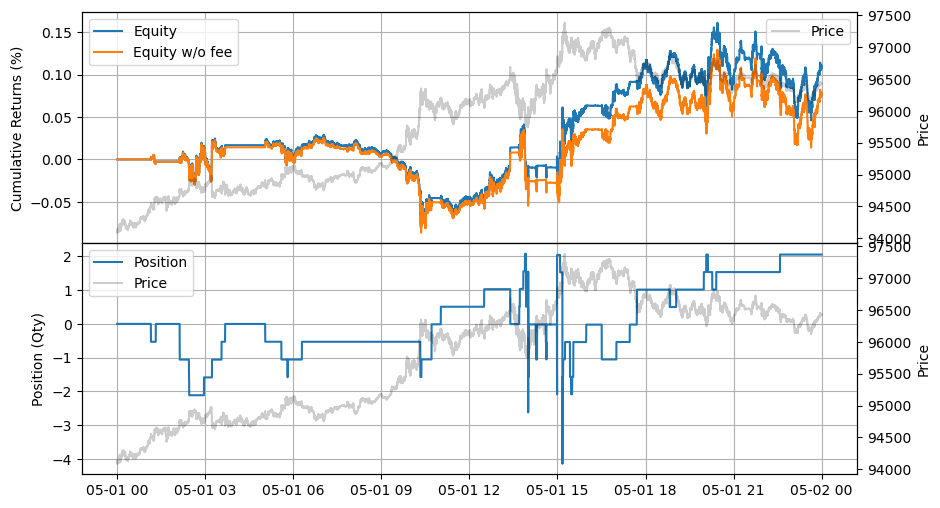

In [20]:
stats.plot()

In [21]:
asset = (
    BacktestAsset()
        .data(['BTCUSDT_fused_20250501.npz'])
        .linear_asset(1.0) 
        .intp_order_latency(['../latency/order_latency_20250501.npz'])
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

basic_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval
)

_ = hbt.close()

### Backtesting with Fused Data

In [22]:
data = recorder.get(0)
stats = (
    LinearAssetRecord(data)
        .resample('1s')
        .stats(book_size=1_000_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-05-01 00:00:00,2025-05-01 23:59:59,10.345893,14.320701,0.001011,0.001167,119.001377,5.950202,0.865768,0.00017,301079.3632


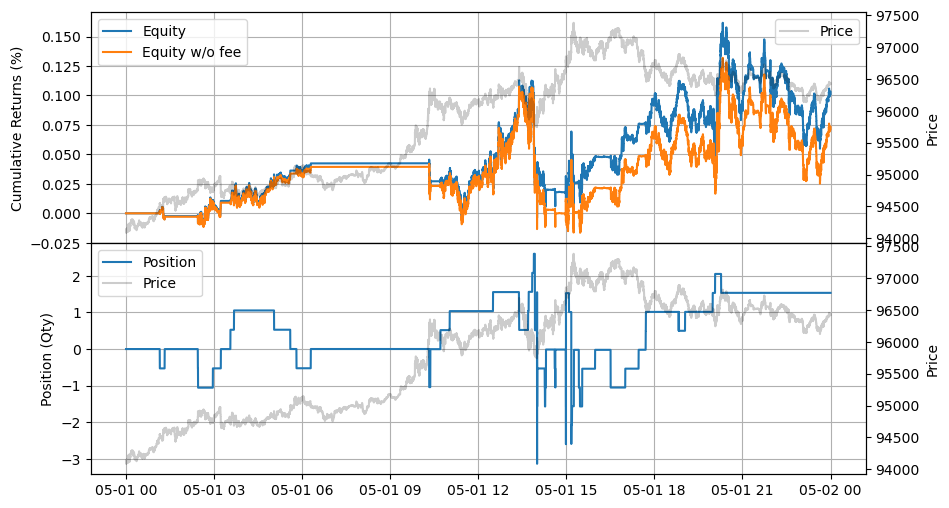

In [23]:
stats.plot()

You may notice slight differences in order fills, which lead to position discrepancies and, ultimately, equity differences — particularly between 03:00 and 15:00. These order fill differences are closely tied to the order placement behavior, which depends on the characteristics of the strategy. The differences in the BBO as shown above can result in significant equity divergence during backtesting.

<div class="alert alert-info">

**Note:** Some tutorial—especially older ones—were not backtested with fused market depth.

</div>

## Wrapping up

Since it uses more frequent data feeds, the backtesting process takes longer. There is always a trade-off between accuracy and speed in backtesting—there is no one-size-fits-all solution. Relaxing certain conditions, such as order queue position and latency modeling, can significantly speed up the process. Not all strategies require precise modeling of these factors, especially when dealing with small tick sizes and highly volatile assets like BTCUSDT. Please see [the next tutorial](https://hftbacktest.readthedocs.io/en/latest/tutorials/Accelerated%20Backtesting.html) about accelerated backtesting.